In [1]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

simulation_folder = '/nfshome/winkelmann/Simulations/running_sims/with_(not)perfect_starting_cells/'

# find files to plot

In [5]:
simulation_concentrations = glob.glob(simulation_folder + 'Li_*')

simulation_files = {}
for conc in simulation_concentrations:
    if not os.path.isdir(conc):
        continue
    concentration = float(conc.split('/')[-1].strip('Li_'))
    simulation_files[str(concentration)] = glob.glob(conc + '/*/state_snapshot.csv')

In [ ]:
# for old folders named Va_concentration
simulation_concentrations = glob.glob(simulation_folder + 'Va_*')

simulation_files = {}
for conc in simulation_concentrations:
    concentration = 100 - float(conc.split('/')[-1].strip('Va_'))
    if concentration == 13:
        concentration = 12.5
    elif concentration == 63:
        concentration = 62.5
    elif concentration == 88:
        concentration = 87.5
    simulation_files[str(concentration)] = glob.glob(conc + '/*/state_snapshot.csv')

# read files and save MSD; Net-MSD and time

In [8]:
# todo: change to store all MSD-t points in one list per concentration, and eleminate unuseful lines (check commented out lines for use)

dict_results = {}

for conc,files in simulation_files.items():
    df_msd = pd.DataFrame()
    #df_net = pd.DataFrame()
    #df_conc = pd.DataFrame()
    for f in files:
        # Read CSV file and strip all whitespace characters (spaces, tabs, newlines)
        df_temp = pd.read_csv(f,sep=r',\s+',skiprows=1, skipfooter=1, engine='python') # Skip first row and last row
        simulation_number = f.split('/')[-2]
        df_msd = pd.concat([df_msd, df_temp])
        #df_net[simulation_number] = df_temp['Net-MSD']
        #if simulation_number == '01':
        #    df_conc['time'] = df_temp['time in 1e+00 s']             
    #df_conc['msd'] = df_msd.mean(axis=1)
    #df_conc['net'] = df_net.mean(axis=1)
    #df_conc['msd_std'] = df_msd.std(axis=1)
    #df_conc['net_std'] = df_net.std(axis=1)
    #print(f'NaN time:\t{df_conc["time"].isna().sum()} MSD:\t{df_conc["msd"].isna().sum()} Net:\t{df_conc["net"].isna().sum()} for concentration\t{conc}')
    dict_results[conc] = df_msd

In [9]:
#print files with all data points together
for conc,df in dict_results.items():
    df.sort_values(by=['time in 1e+00 s'], inplace=True)
    df.to_csv(simulation_folder + f'all_datapoints_{conc}.csv', index=False)

# Plot

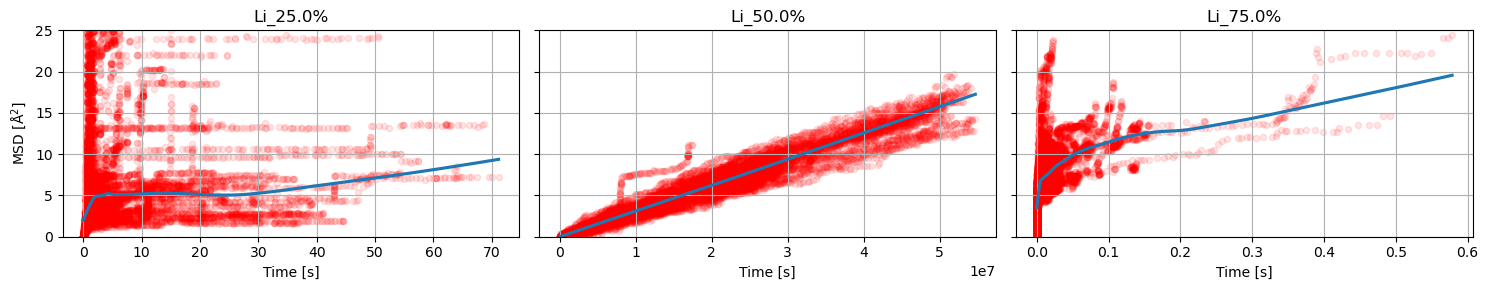

In [ ]:
# MSD subplots per concentration

#todo: check commented out lines for use
concs = sorted(dict_results.keys(), key=float)
n = len(concs)
cols = min(3, n)               # choose columns (adjust)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows), sharex=True, sharey=True)
axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, conc in enumerate(concs):
    ax = axes_flat[i]
    df = dict_results[conc]
    
    # plot per-subplot (no CI fill)
    sns.regplot(x=df['time in 1e+00 s'], y=df['MSD-Li'], ax=ax, scatter_kws={'s':20, 'alpha':0.1, 'color':'red'}, ci=95, order=1, lowess=True)

    ax.set_title(f'Li_{conc}%')

    #ax.set_xlim(0, 2e-5)
    #ax.set_ylim(0, 20)
    ax.grid(True)

for ax in axes.flat:
    ax.set(xlabel='Time [s]', ylabel=f'MSD [$\mathrm{{\AA}}^2$]')

# Hide x labels and tick labels for all plots that are not 
for ax in axes.flat:
    ax.label_outer()

plt.legend([], [], frameon=False)
plt.tight_layout()
fig.savefig(f'{simulation_folder}kmc_MSD_all_concentrations_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

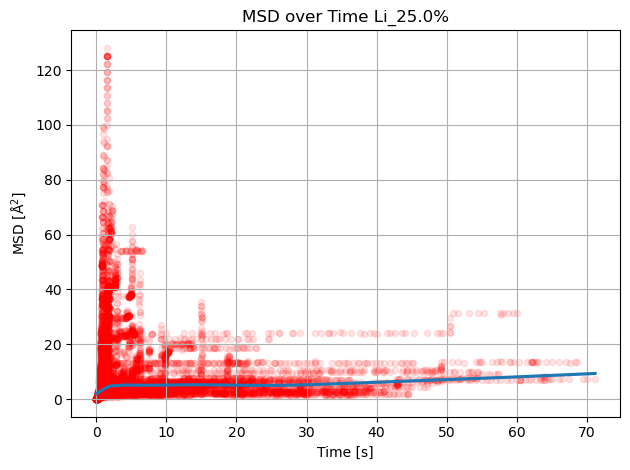

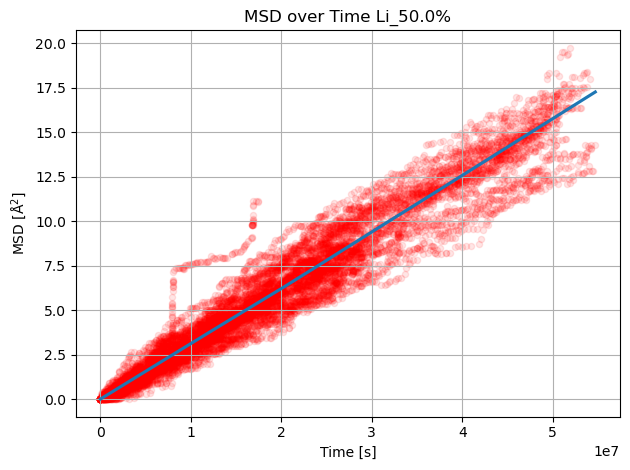

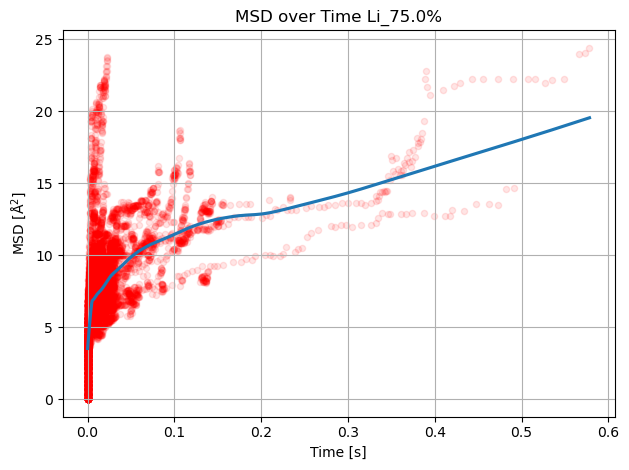

In [15]:
# MSD but all concentrations individual plots
for conc in sorted(dict_results.keys(), key=float):
    df = dict_results[conc]
    sns.regplot(x=df['time in 1e+00 s'], y=df['MSD-Li'], scatter_kws={'s':20, 'alpha':0.1, 'color':'red'}, ci=95, order=1, lowess=True)
    plt.xlabel('Time [s]')
    plt.ylabel(f'MSD [$\mathrm{{\AA}}^2$]')
    plt.title(f'MSD over Time Li_{conc}%')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{simulation_folder}kmc_MSD_{conc}.png', dpi=300)
    plt.show()

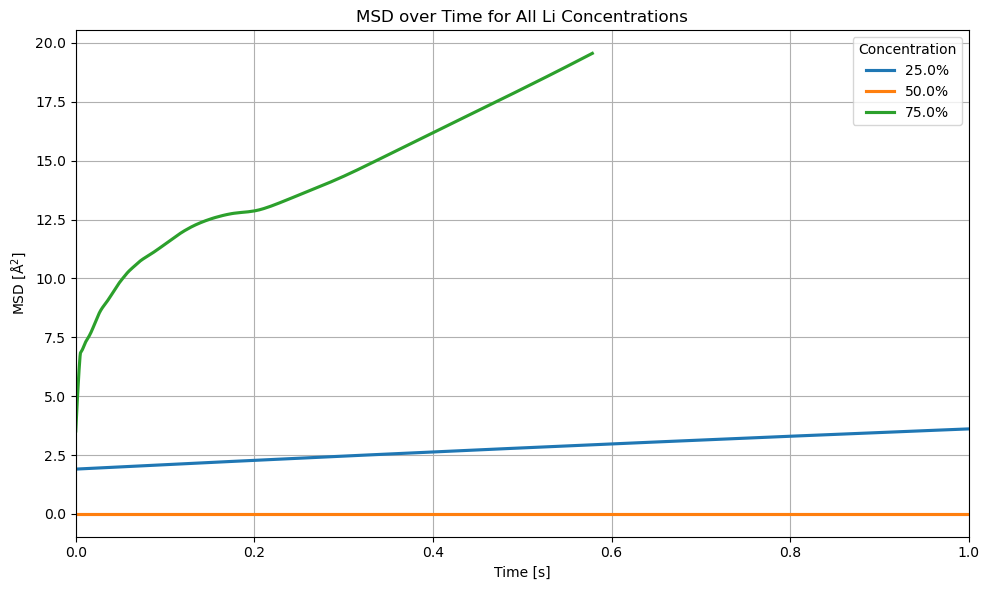

In [16]:
# MSD regression all concentrations - one plot
plt.figure(figsize=(10, 6))
for conc in sorted(dict_results.keys(), key=float):
    df = dict_results[conc]
    sns.regplot(x=df['time in 1e+00 s'], y=df['MSD-Li'], scatter=False, label=f'{conc}%', line_kws={'label': f'{conc}%'}, ci=95, order=1, lowess=True)
    
    
# manually set highest graph limits for better visibility
plt.xlim(0, 1)   
#plt.ylim(0, 1)

plt.xlabel('Time [s]')
plt.ylabel(f'MSD [$\mathrm{{\AA}}^2$]')
plt.title('MSD over Time for All Li Concentrations')
plt.legend(title='Concentration')
plt.grid()
plt.tight_layout()
plt.savefig(f'{simulation_folder}kmc_MSD_all_concentrations.png', dpi=300)
plt.show()

In [ ]:
# todo: # Calculate and plot the first derivative (numerical gradient) of the mean Net-MSD for all concentrations

plt.figure(figsize=(10, 6))
for conc, df in dict_results.items():
    # Calculate the first derivative using numpy.gradient
    d_net = np.gradient(df['MSD-Li'], df['time in 1e+00 s'])
    plt.plot(df['time'], d_net, label=f'{conc}%')

plt.ylim(2e-6, 2e-5)  # Set y-axis limits for better visibility
plt.xlabel('Time [s]')
plt.ylabel('d(Net-MSD)/dt [$\mathrm{{\AA}}^2$/s]')
plt.title('First Derivative of Net-MSD over Time for All Concentrations')
plt.legend(title='Concentration')
plt.grid()
plt.tight_layout()
plt.savefig(f'{simulation_folder}kmc_NetMSD_derivative_all_concentrations.png', dpi=300)
plt.show()

/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/nfshome/winkelmann/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid 

KeyError: 'time'

<Figure size 1000x600 with 0 Axes>